## Notebook to bulk download PlanetScope imagery through the API
Rainey Aberle, Fall 2021

Modified from [Planet Developers API Tutorial](https://developers.planet.com/docs/apis/data/) and Planet Labs GitHub Repository: [planetlabs/notebooks/jupyter-notebooks/orders/](https://github.com/planetlabs/notebooks/tree/master/jupyter-notebooks/orders)


__To-Do:__
- View image footprints before downloading.  
- Implement percent AOI coverage filter for image search

### 1. Define paths in directory and setup filters for image search (MODIFY THIS SECTION)

In [1]:
# -----Define paths in directory
# path to planet-snow/
base_path = '/Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/' 
# path for saving image downloads
out_path = base_path+'../study-sites/Sperry/imagery/Planet/'

# -----Area of Interest (AOI)
# Name of your polygon shapefile
# If your shapefile is not currently in this directory, you need to include the full file path in 'file_name' below
AOI_fn = base_path+'../../GIS_data/RGI_outlines/Sperry_RGI.shp'

# ----------Date Range----------
# Format: 'YYYY-MM-DD'
start_date = '2020-05-01'
end_date = '2020-10-31'

# ----------Cloud Cover Filter----------
# Format: decimal (e.g., 50% max cloud cover = 0.5)
max_cloud_cover = 0.2

# ----------Area Coverage (NOT CURRENTLY WORKING)---------- 
# Format: decimal (e.g., 50% min AOI bounding box area coverage = 0.5)
# min_area_coverage = 0.6

# ----------Item Type----------
# See here for possible image ("item") types:
# https://developers.planet.com/docs/apis/data/items-assets/
item_type = "PSScene4Band"

# ----------Asset Type----------
# Each Item Type has a number of asset types to choose from.
# Use the Item Type link above click on your Item Type to view the available Asset Types
asset_type = "analytic_sr"

# ----------AOI clipping----------
# Would you like to clip images to the AOI (True/False)?
# This greatly speeds up the ordering and downloading process.
clip_to_AOI = True

# ----------Harmonization----------
# option to harmonize PlanetScope imagery to Sentinel-2
harmonize = False # = True to harmonize

In [2]:
# -----Import packages
import os
import json
import requests
from requests.auth import HTTPBasicAuth
from getpass import getpass
import geopandas as gpd
from shapely import geometry as sgeom
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import sys
# add path to functions
sys.path.insert(1, base_path+'functions/')
import orders_utils as orders
from IPython.display import Image

/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/planet/api/__init__.py:38: ClientV1DeprecationWarning: The planet.api module is deprecated and will be removed in version 2.0.0. For more details please see the discussion at https://github.com/planetlabs/planet-client-python/discussions.
  warnings.warn(


### 2. Reformat AOI for querying

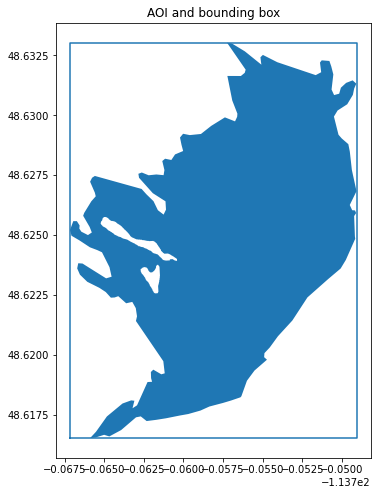

In [3]:
# -----Read in the shapefile
AOI = gpd.read_file(AOI_fn)
# Reproject to WGS84 if necessary
AOI = AOI.to_crs(4326)

# -----Convert AOI bounding box to geoJSON format
# Planet only excepts a bounding box as a spatial filter, 
# so we need to convert our AOI to a box (if it is not already). 
AOI_box = {u'type': u'Polygon',
            u'coordinates': [[
               [AOI.bounds.minx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.miny[0]],
               [AOI.bounds.maxx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.maxy[0]],
               [AOI.bounds.minx[0],AOI.bounds.miny[0]]
            ]]
          }
# Convert AOI geojson to a rasterio Shape for Quick Search function
AOI_box_shape = sgeom.shape(AOI_box)

# -----Plot AOI and bounding box
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
AOI.plot(ax=ax1) # AOI
ax1.plot(*AOI_box_shape.exterior.xy) # AOI box
ax1.set_title('AOI and bounding box')
plt.show()

### 3. Authentication via basic HTTP

Requires your Planet API Key. To find your API Key, Login to your account at [planet.com](https://www.planet.com/) and go to 'My Settings'. 

In [4]:
# set API key as environment variable
print('Enter Planet API key:')
API_key = getpass()
os.environ['PL_API_KEY'] = API_key

# Setup the API Key stored as the `PL_API_KEY` environment variable
PLANET_API_KEY = os.getenv('PL_API_KEY')

# Orders URL
orders_url = 'https://api.planet.com/compute/ops/orders/v2'

# Authorize
auth = HTTPBasicAuth(PLANET_API_KEY, '')
response = requests.get(orders_url, auth=auth)
response

Enter Planet API key:
········


<Response [200]>

### 4. Compile filters to create a Quick Search request

Use Quick Search first to grab image IDs before ordering

In [5]:
# -----Create request
QS_request = orders.build_QS_request(AOI_box_shape, max_cloud_cover, start_date, end_date, 
                        item_type, asset_type)

# -----Planet API Quick Search using created request
# fire off the POST request
QS_result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PLANET_API_KEY, ''),
    json=QS_request)
# Print resulting image IDs
im_ids = [feature['id'] for feature in QS_result.json()['features']]
im_ids.sort()
print(len(im_ids),'images found')

202 images found


In [ ]:
# -----Filter images by area coverage (NOT WORKING)
# if min_area_coverage < 1.0:
#     items = orders.search_pl_api(QS_request, limit=1000)
#     # cache the overlaps as a list so we don't have to refetch items
#     overlaps = list(orders.get_overlap_shapes_utm(items, AOI_box_shape))
#     print(len(overlaps))

# display(orders.calculate_coverage(overlaps, (6,3), AOI_box_UTM_shape.bounds))

# def filter_by_coverage(overlaps, bounds):
#     im_ids_filtered = []
    
#     # get dimensions of coverage raster
#     mminx, mminy, mmaxx, mmaxy = bounds

#     y_count, x_count = dimensions
    
    
# AOI_box_UTM_shape.bounds

### 5. Place order and poll for success

- This section places the order and outputs the status of the order every ~10 sec. if successful. This can take a few minutes... 
- Wait until it outputs `success` to proceed to the next section. It will stop after 30 loops, so try rerunning the 'Poll for success' cell until seeing `success`.
- If you are ordering a LOT of images, consider narrowing your date range to download less images at a time. 

In [6]:
# -----Build new request
request = orders.build_request_itemIDs(AOI_box, clip_to_AOI, harmonize, im_ids, item_type, asset_type)

# -----Place order
order_url = orders.place_order(orders_url, request, auth)

{'_links': {'_self': 'https://api.planet.com/compute/ops/orders/v2/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52'}, 'created_on': '2022-08-07T20:41:13.057Z', 'error_hints': [], 'id': '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52', 'last_message': 'Preparing order', 'last_modified': '2022-08-07T20:41:13.057Z', 'name': 'simple order', 'products': [{'item_ids': ['20200511_175631_0e26', '20200609_175527_57_1062', '20200626_154507_1_0f49', '20200725_175403_21_106e', '20200912_175250_50_106a', '20201003_182602_08_105c', '20201006_152844_1_0f44', '20201008_180853_1009', '20200510_155330_0f36', '20200529_181235_1034', '20200530_181056_1035', '20200809_175353_15_1063', '20200829_181218_0f17', '20200829_181408_1002', '20201008_174850_39_1062', '20201015_181414_1032', '20200612_180924_1010', '20200706_181500_1038', '20200727_154338_104e', '20200823_153730_0f46', '20200827_175837_0e20', '20200918_174958_26_2259', '20200602_181123_1034', '20200713_154448_1052', '20201007_174752_70_2278', '20201024_174817_32_2231', 

In [10]:
# -----Poll for success
# Rerun this cell until it outputs "success"
orders.poll_for_success(order_url, auth)

success


In [11]:
# -----View results
r = requests.get(order_url, auth=auth)
response = r.json()
results = response['_links']['results']
# print all files to be downloaded from order
[r['name'] for r in results]

['9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_metadata.json',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_3B_AnalyticMS_SR_clip.tif',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_3B_AnalyticMS_metadata_clip.xml',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_3B_AnalyticMS_DN_udm_clip.tif',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_181056_1035_metadata.json',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_181056_1035_3B_AnalyticMS_metadata_clip.xml',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_181056_1035_3B_AnalyticMS_SR_clip.tif',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_181056_1035_3B_AnalyticMS_DN_udm_clip.tif',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201003_182602_08_105c_metadata.json',
 '9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201003_182602_08_105c_3B_AnalyticMS_SR_cli

### 6. Download each asset individually

In [12]:
orders.download_results(results, out_path)

809 items to download
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201006_152844_1_0f44_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PS

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201008_180853_1009_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201008_180853_1009_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200510_155330_0f36_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200510_155330_0f36_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200510_155330_0f36_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200510_155330_0f36_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200725_175403_21_106e_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200725_175403_21_106e_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200725_175403_21_106e_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200725_175403_21_106e_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200602_181123_1034_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200602_181123_1034_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200612_180924_1010_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200612_180924_1010_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200612_180924_1010_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200612_180924_1010_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200612_180924_1010_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200612_180924_1010_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200827_175837

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_181500_1038_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_181500_1038_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_181500_1038_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_181500_1038_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_181500_1038_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_181500_1038_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_181500_1038_3B

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200709_184104_10_1057_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200709_184104_10_1057_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201024_174817_32_2231_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201024_174817_32_2231_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201024_174817_32_2231_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201024_174817_32_2231_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200619_181338_0f15_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200619_181338_0f15_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200619_181338_0f15_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200619_181338_0f15_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200804_181127_1034_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200804_181127_1034_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_175237_64_106a_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_175237_64_106a_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_175237_64_106a_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_175237_64_106a_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_175237_64_106a_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_175237_64_106a_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Ba

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200508_181232_103c_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200508_181232_103c_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200508_181232_103c_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200508_181232_103c_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200508_181232_103c_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200508_181232_103c_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200508_181232_103c_3B_Ana

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_174312_40_2235_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_174312_40_2235_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200714_181059_1038_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200714_181059_1038_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200714_181059_1038_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200714_181059_1038_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200714_

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200613_181158_103c_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200613_181158_103c_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200613_181158_103c_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200613_181158_103c_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200626_181522_0f28_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200626_181522_0f28_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSSc

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_183851_47_1057_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_183851_47_1057_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_183851_47_1057_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_183851_47_1057_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_183851_47_1057_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_183851_47_1057_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Ba

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200727_154337_104e_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200727_154337_104e_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200727_154337_104e_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200727_154337_104e_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200727_154337_104e_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200727_154337_104e_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200727_154337_104e_3B_Ana

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200601_181225_103c_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200601_181225_103c_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200816_175239_58_1069_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200816_175239_58_1069_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200816_175239_58_1069_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200816_175239_58_1069_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200815_181652_0f4e_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200815_181652_0f4e_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200815_181652_0f4e_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200815_181652_0f4e_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201007_174750_31_2278_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201007_174750_31_2278_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc5

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200930_174857_07_1062_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200930_174857_07_1062_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200930_174857_07_1062_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200930_174857_07_1062_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200930_174857_07_1062_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200930_174857_07_1062_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181507_101b_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181507_101b_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181507_101b_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181507_101b_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181507_101b_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181507_101b_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181507

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_181010_1012_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200908_181010_1012_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_175644_58_106a_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_175644_58_106a_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_175644_58_106a_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_175644_58_106a_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200530_175644_58_106a_3B_AnalyticMS_m

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200703_181235_1018_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200703_181235_1018_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200703_181235_1018_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200703_181235_1018_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181138_1006_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181138_1006_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200905_181138

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200718_154245_1052_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200718_154245_1052_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200718_154245_1052_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200718_154245_1052_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200718_154245_1052_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200718_154245_1052_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_174658

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200517_175751_84_106e_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200517_175751_84_106e_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200517_175751_84_106e_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200517_175751_84_106e_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200517_175751_84_106e_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200517_175751_84_106e_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Ba

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200904_175437_0e20_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200904_175437_0e20_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200730_181051_1001_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200730_181051_1001_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200730_181051_1001_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200730_181051_1001_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200730_181051_1001_3B_Ana

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200515_155258_0f36_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200515_155258_0f36_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200515_155258_0f36_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200515_155258_0f36_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201003_182559_60_105c_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201003_182559_60_105c_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201003_182559_6

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200810_153940_1_0f36_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200810_153940_1_0f36_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200810_153940_1_0f36_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200810_153940_1_0f36_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200810_153940_1_0f36_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200810_153940_1_0f36_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200721_175538_0e26_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200721_175538_0e26_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200721_175538_0e26_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200721_175538_0e26_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200721_175538_0e26_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200721_175538_0e26_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200721_175538_0e26_3B

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201005_174359_09_2212_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201005_174359_09_2212_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200809_175351_62_1063_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200809_175351_62_1063_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200809_175351_62_1063_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200809_175351_62_1063_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200809_175351_62_1063_3B_AnalyticMS_met

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200704_175546_21_1068_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200704_175546_21_1068_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200704_175546_21_1068_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200704_175546_21_1068_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_181329_1011_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_181329_1011_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200509_18

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200713_154449_1052_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200713_154449_1052_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200713_154449_1052_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200713_154449_1052_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200713_154449_1052_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200713_154449_1052_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSSc

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_181315_1005_3B_AnalyticMS_SR_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_181315_1005_3B_AnalyticMS_SR_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_181315_1005_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_181315_1005_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_181315_1005_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_181315_1005_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200915_181315_1005_3B

downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201009_181847_1026_3B_AnalyticMS_DN_udm_clip.tif to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20201009_181847_1026_3B_AnalyticMS_DN_udm_clip.tif
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_175207_38_106b_metadata.json to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_175207_38_106b_metadata.json
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_175207_38_106b_3B_AnalyticMS_metadata_clip.xml to /Users/raineyaberle/Research/PhD/Planet_snow_cover/planet-snow/../study-sites/Sperry/imagery/Planet/9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/20200706_175207_38_106b_3B_AnalyticMS_metadata_clip.xml
downloading 9bdd53cd-dd5e-4223-a12d-9fb91b4ecc52/PSScene4Band/202

### _Optional:_ Plot downloaded images

In [ ]:
import glob 

# -----Grab output image file names
# set image output folder
im_path = out_path + '2020/PSScene4Band/'
# change directory to im_path
os.chdir(im_path) 
# grab image file names
im_fns = glob.glob('*_SR_*.tif')

# -----Loop through files
for im_fn in im_fns:
    
    # open image
    im = rio.open(im_fn)
    
    # read bands
    b = im.read(1).astype(float) / 10000
    r = im.read(2).astype(float) / 10000
    g = im.read(3).astype(float) / 10000
    nir = im.read(4).astype(float) / 10000
    
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.imshow(np.dstack([r, g, b]))
    ax.set_title(im_fn[0:8])
    plt.show()